In [80]:
optimized_paths = {"LDBC01":"ldbc01/ldbc01_statistic.pkl", 
         "LDBC10":"ldbc10/ldbc10_statistic.pkl", 
         "Pokec":"pokec/pokec_statistic.pkl",
         "Telecom":"telecom/telecom_statistic.pkl",
           "ICIJ-Paradises": "paradise/icij_paradise_statistic.pkl",
            "ICIJ-Leaks":"icij-leak/icij_leak_statistic.pkl"}
        


log_paths = {"L0":"ldbc01/z3_debug.log", 
         "L1":"ldbc10/z3_debug.log", 
         "PO":"pokec/z3_debug.log",
         "TE":"telecom/z3_debug.log",
           "IP": "paradise/z3_debug.log",
            "IL":"icij-leak/z3_debug.log"}

data_stat = {
    "LDBC10":(30000000, 178000000),
    "LDBC01":(180000, 1500000),
    "Pokec":(1632803,30622564  ), 
    "Telecom":(170000, 50000000), 
     "ICIJ-Leaks":(1908466,  3193390),
     "ICIJ-Paradises":(163414, 364456)
}
dataset_names = ["LDBC01", "LDBC10", "Pokec", "Telecom", "ICIJ-Paradises", "ICIJ-Leaks"]

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import os

def slice_small_log(path):
    f = open(path, "rb+") 
    count = 0 
    res = []
    d = {}
    for qi in range(12):
        d[f"Q{qi+1}"] = {}
    for line in f:
        if "exploration_depth" in line.decode('utf-8'):
            res.append(int(line.decode('utf-8').split(":")[1].strip()))
    for i in range(12):
        for j in range(5):
            d[f"Q{i+1}"][f"D{j+1}"] = res[i*500 + j*100: i*500 + (j+1)*100]
    return d

def load_running_time_data(path, dataset_name):
    """Load running time data from pickle file"""
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    time_data = {}
    for i in range(12):  # Q1-Q12
        query_key = f"Q{i+1}"
        time_data[query_key] = {}
        
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:  # Skip RPQ
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            time_data[query_key][dtype] = values
            id += 1
    
    return time_data

def classify_queries():
    """Define query complexity classifications"""
    return {
        'simple_regular': ['Q1', 'Q2', 'Q4', 'Q7', 'Q11'],
        'medium_regular': ['Q5', 'Q6', 'Q9', 'Q10'],
        'complex_regular': ['Q3', 'Q8', 'Q12'],
        'simple_data': ['D1', 'D2'],
        'complex_data': ['D3', 'D4', 'D5']
    }

In [ ]:
def prepare_original_cardinality_data(cardinality_data, dataset_name):
    """Prepare original cardinality data for visualization"""
    query_classes = classify_queries()
    plot_data = []
    
    for query_key, query_data in cardinality_data.items():
        # Determine regular query complexity
        reg_complexity = None
        for complexity, queries in query_classes.items():
            if 'regular' in complexity and query_key in queries:
                reg_complexity = complexity
                break
        
        for constraint, values in query_data.items():
            # Determine data constraint complexity
            data_complexity = None
            if constraint in query_classes['simple_data']:
                data_complexity = 'simple_data'
            elif constraint in query_classes['complex_data']:
                data_complexity = 'complex_data'
            
            for value in values:
                plot_data.append({
                    'dataset': dataset_name,
                    'query': query_key,
                    'constraint': constraint,
                    'cardinality': value,
                    'regular_complexity': reg_complexity,
                    'data_complexity': data_complexity
                })
    
    return pd.DataFrame(plot_data)
def plot_violin_distributions(all_cardinality_data):
    """Create violin plots showing distribution of original cardinality data with log scale"""
    
    os.makedirs('figure/violin_distributions', exist_ok=True)
    
    # Combine all datasets
    all_data = []
    for dataset_name, df in all_cardinality_data.items():
        all_data.append(df)
    
    merged_df = pd.concat(all_data, ignore_index=True)
    
    # Get unique datasets for ordering
    datasets = merged_df['dataset'].unique()
    
    # Check data range
    min_val = merged_df['cardinality'].min()
    max_val = merged_df['cardinality'].max()
    print(f"Data range: {min_val} to {max_val}")
    
    # 1. Data constraint violin plot (one figure)
    plot_data_constraint_violin(merged_df, datasets)
    
    # 2. Regular constraint violin plot (one figure)
    plot_regular_constraint_violin(merged_df, datasets)
    
    return merged_df

def plot_data_constraint_violin(df, datasets):
    """Single violin plot for data constraints (simple vs complex) with log scale"""
    
    # Filter for data queries only
    data_df = df[df['data_complexity'].notnull()].copy()
    
    if len(data_df) == 0:
        print("No data for data constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Create violin plot with adjusted parameters for log scale
    sns.violinplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',
                   ax=ax, split=True, inner='quartile', palette='Set2', order=datasets,
                   bw=0.6,  # Increased bandwidth for log scale
                   scale='width',  # Scale by width for better visibility
                   width=0.9,  # Increased width
                   cut=0)
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    ax.set_ylim(bottom=0)
    # Set titles and labels

    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Oracle Query Count', fontsize=40)
    ax.tick_params("y", labelsize=40)
    ax.tick_params("x", labelsize=40)    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Data', 'Complex Data']
    ax.legend(handles, new_labels, fontsize=40, ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1.2))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    min_val = data_df['cardinality'].min()
    max_val = data_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/violin_distributions/data_constraint_violin_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print("Created data constraint violin plot with log scale")

def plot_regular_constraint_violin(df, datasets):
    """Single violin plot for regular constraints (simple, medium, complex) with log scale"""
    
    # Filter for regular queries only
    regular_df = df[df['regular_complexity'].notnull()].copy()
    
    if len(regular_df) == 0:
        print("No data for regular constraint violin plot")
        return
    
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Create violin plot with adjusted parameters for log scale
    sns.violinplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',
                   ax=ax, split=True, inner='quartile', palette='Set3', order=datasets,
                   bw=0.6,  # Increased bandwidth for log scale
                   scale='width',  # Scale by width for better visibility
                   width=0.9,  # Increased width
                   cut=0)
    
    # Set logarithmic y-scale
    ax.set_yscale('log')
    ax.set_ylim(bottom=0)
    # Set titles and labels

    ax.set_xlabel('', fontsize=40)
    ax.set_ylabel('Oracle Query Count', fontsize=40)
    ax.tick_params(labelsize=40)
    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ['Simple Regular', 
                 'Medium Regular', 
                 'Complex Regular']
    ax.legend(handles, new_labels, fontsize=30, ncol=3,  loc='upper center', bbox_to_anchor=(0.5,1.1))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add data range information
    min_val = regular_df['cardinality'].min()
    max_val = regular_df['cardinality'].max()
    # ax.text(0.02, 0.98, f'Data range: {min_val} - {max_val}', 
    #        transform=ax.transAxes, fontsize=10,
    #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = 'figure/violin_distributions/regular_constraint_violin_plot_log.pdf'
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()
    
    print("Created regular constraint violin plot with log scale")

def analyze_cardinality_distributions(cardinality_paths):
    """
    Main function to analyze cardinality distributions with violin plots using log scale
    """
    
    all_cardinality_data = {}
    
    print("Loading and processing data...")
    
    # Load cardinality data only
    for dataset_name, path in cardinality_paths.items():
        print(f"  Loading cardinality data for {dataset_name}...")
        cardinality_data = slice_small_log(path)
        cardinality_df = prepare_original_cardinality_data(cardinality_data, dataset_name)
        all_cardinality_data[dataset_name] = cardinality_df
    
    # Create violin plots for cardinality distribution with log scale
    print("Creating violin plots with logarithmic scale...")
    merged_cardinality_df = plot_violin_distributions(all_cardinality_data)
    
    print("\nAnalysis complete!")
    print(f"Total cardinality data points: {len(merged_cardinality_df):,}")
    print(f"Number of datasets: {len(all_cardinality_data)}")
    print(f"Cardinality range: {merged_cardinality_df['cardinality'].min()} to {merged_cardinality_df['cardinality'].max()}")
    
    # Print summary
    print("\nCreated the following files:")
    print("- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)")
    print("- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)")


In [122]:
analyze_cardinality_distributions(log_paths)

Loading and processing data...
  Loading cardinality data for L0...
  Loading cardinality data for L1...
  Loading cardinality data for PO...
  Loading cardinality data for TE...
  Loading cardinality data for IP...
  Loading cardinality data for IL...
Creating violin plots with logarithmic scale...
Data range: 1 to 30708


/tmp/ipykernel_784/2292202423.py:74: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',
/tmp/ipykernel_784/2292202423.py:74: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.6`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',
/tmp/ipykernel_784/2292202423.py:83: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


Created data constraint violin plot with log scale


/tmp/ipykernel_784/2292202423.py:127: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',
/tmp/ipykernel_784/2292202423.py:127: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.6`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',
/tmp/ipykernel_784/2292202423.py:136: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=0)


Created regular constraint violin plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 1 to 30708

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [61]:
analyze_cardinality_distributions(log_paths)

Loading and processing data...
  Loading cardinality data for LDBC01...
  Loading cardinality data for LDBC10...
  Loading cardinality data for Pokec...
  Loading cardinality data for Telecom...
  Loading cardinality data for ICIJ-Paradises...
  Loading cardinality data for ICIJ-Leaks...
Creating violin plots with logarithmic scale...
Data range: 1 to 30708


/tmp/ipykernel_784/1031127203.py:74: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',
/tmp/ipykernel_784/1031127203.py:74: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.6`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=data_df, x='dataset', y='cardinality', hue='data_complexity',


Created data constraint violin plot with log scale


/tmp/ipykernel_784/1031127203.py:128: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',
/tmp/ipykernel_784/1031127203.py:128: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.6`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(data=regular_df, x='dataset', y='cardinality', hue='regular_complexity',


Created regular constraint violin plot with log scale

Analysis complete!
Total cardinality data points: 36,000
Number of datasets: 6
Cardinality range: 1 to 30708

Created the following files:
- 1 data constraint violin plot with log scale (showing D1-D2 vs D3-D5 across all datasets)
- 1 regular constraint violin plot with log scale (showing simple/medium/complex queries across all datasets)


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

def plot_time_distribution_by_constraint(path, path2, ds, name1="Optimized", name2="Naive", timeout=10):
    """
    Plot time distribution by data constraint complexity using box plots
    - Simple: D1, D2
    - Complex: D3, D4, D5
    """
    # Load both datasets
    with open(path, "rb+") as f:
        data1 = pickle.loads(f.read())
    with open(path2, "rb+") as f:
        data2 = pickle.loads(f.read())
    
    # Process both datasets
    data_groups = []
    for dataset, name in [(data1, name1), (data2, name2)]:
        for i in range(12):  # Q1-Q12
            id = 0
            for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
                if id == 0:  # Skip RPQ
                    id += 1
                    continue
                data = list(map(lambda x: x, dataset[i*6 + id][2]))
                id += 1
                data_groups.append((f"Q{i+1}", dtype, name, data))

    # Prepare data
    plot_data = []
    for group, dtype, dataset_name, values in data_groups:
        for value in values:
            plot_data.append({
                'Query': group,
                'Data Constraint': dtype,
                'Dataset': dataset_name,
                'Time': value,
                'IsTimeout': (value / 1000) > timeout
            })
    
    df = pd.DataFrame(plot_data)
    
    # Classify data constraints
    def classify_constraint(dtype):
        if dtype in ['D1', 'D2']:
            return 'Simple'
        elif dtype in ['D3', 'D4', 'D5']:
            return 'Complex'
        return 'Other'
    
    df['Constraint_Complexity'] = df['Data Constraint'].apply(classify_constraint)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.set_style("whitegrid")
    
#  Create violin plot with adjusted parameters
    violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time', 
                           hue='Dataset', ax=ax, split=False,
                           palette=['white', 'grey'], 
                           inner="quartile",  # Show quartiles inside
                           scale='width',     # Scale violins by number of observations
                           bw=0.5,           # Bandwidth adjustment (0.1-1.0)
                           width=0.8)        # Width of violins
    
    # boxplot = sns.boxplot(data=df, x='Constraint_Complexity', y='Time', 
    #                      hue='Dataset', ax=ax, showfliers=False,
    #                      palette=['white', 'grey'])    
    
    # Add individual data points for thin violins
    # sns.stripplot(data=df, x='Constraint_Complexity', y='Time', 
    #               hue='Dataset', ax=ax, dodge=True, jitter=True, 
    #               alpha=0.4, size=2, palette=['black', 'black'])
    # # Add timeout threshold line
    # timeout_ms = timeout * 1000
    # ax.axhline(y=timeout_ms, color='red', linestyle='--', linewidth=2, 
    #           alpha=0.8, label=f'Timeout Threshold ({timeout}s)')
    
    # Customize plot
    ax.set_xlabel('', fontsize=16, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=70, fontweight='bold')
    ax.tick_params(axis='y', labelsize=75)
    # ax.set_title(f'Time Distribution by Data Constraint Complexity\nDataset: {ds}', 
                #  fontsize=18, fontweight='bold')
    ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)

    # Use logarithmic scale if appropriate
    max_time = df['Time'].max()
    min_nonzero = df[df['Time'] > 0]['Time'].min()
    
    if max_time > 0 and min_nonzero > 0 and max_time / min_nonzero > 100:
        ax.set_yscale('log')
        ax.set_ylabel('Time (ms)', fontsize=70, fontweight='bold')
        # ax.set_title(f'Time Distribution by Data Constraint Complexity (log scale)\nDataset: {ds}', 
                    #  fontsize=18, fontweight='bold')
    
  
    legend_elements = [
                # Scatter point elements
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', 
        #        markeredgecolor='black', markersize=40, linestyle='None'),
        # Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
        #        markeredgecolor='black', markersize=40, linestyle='None'),
        # Box plot elements
        Patch(facecolor='white', edgecolor='black', label=name1),
        Patch(facecolor='grey', edgecolor='black', label=name2),
        
            ]
    
    ax.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 1.3), ncol=2, fontsize=75,
              frameon=True, fancybox=True, shadow=True)    
    # Adjust layout
    # plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    
    plt.savefig(f'figure/{ds}-time-distribution-by-constraint.pdf', 
                format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()
    
    return query_df

# save
# Example usage:
# constraint_df = plot_timeout_by_data_constraint("path1.pkl", "path2.pkl", "dataset_name")
# query_df = plot_timeout_by_query_complexity("path1.pkl", "path2.pkl", "dataset_name")

/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


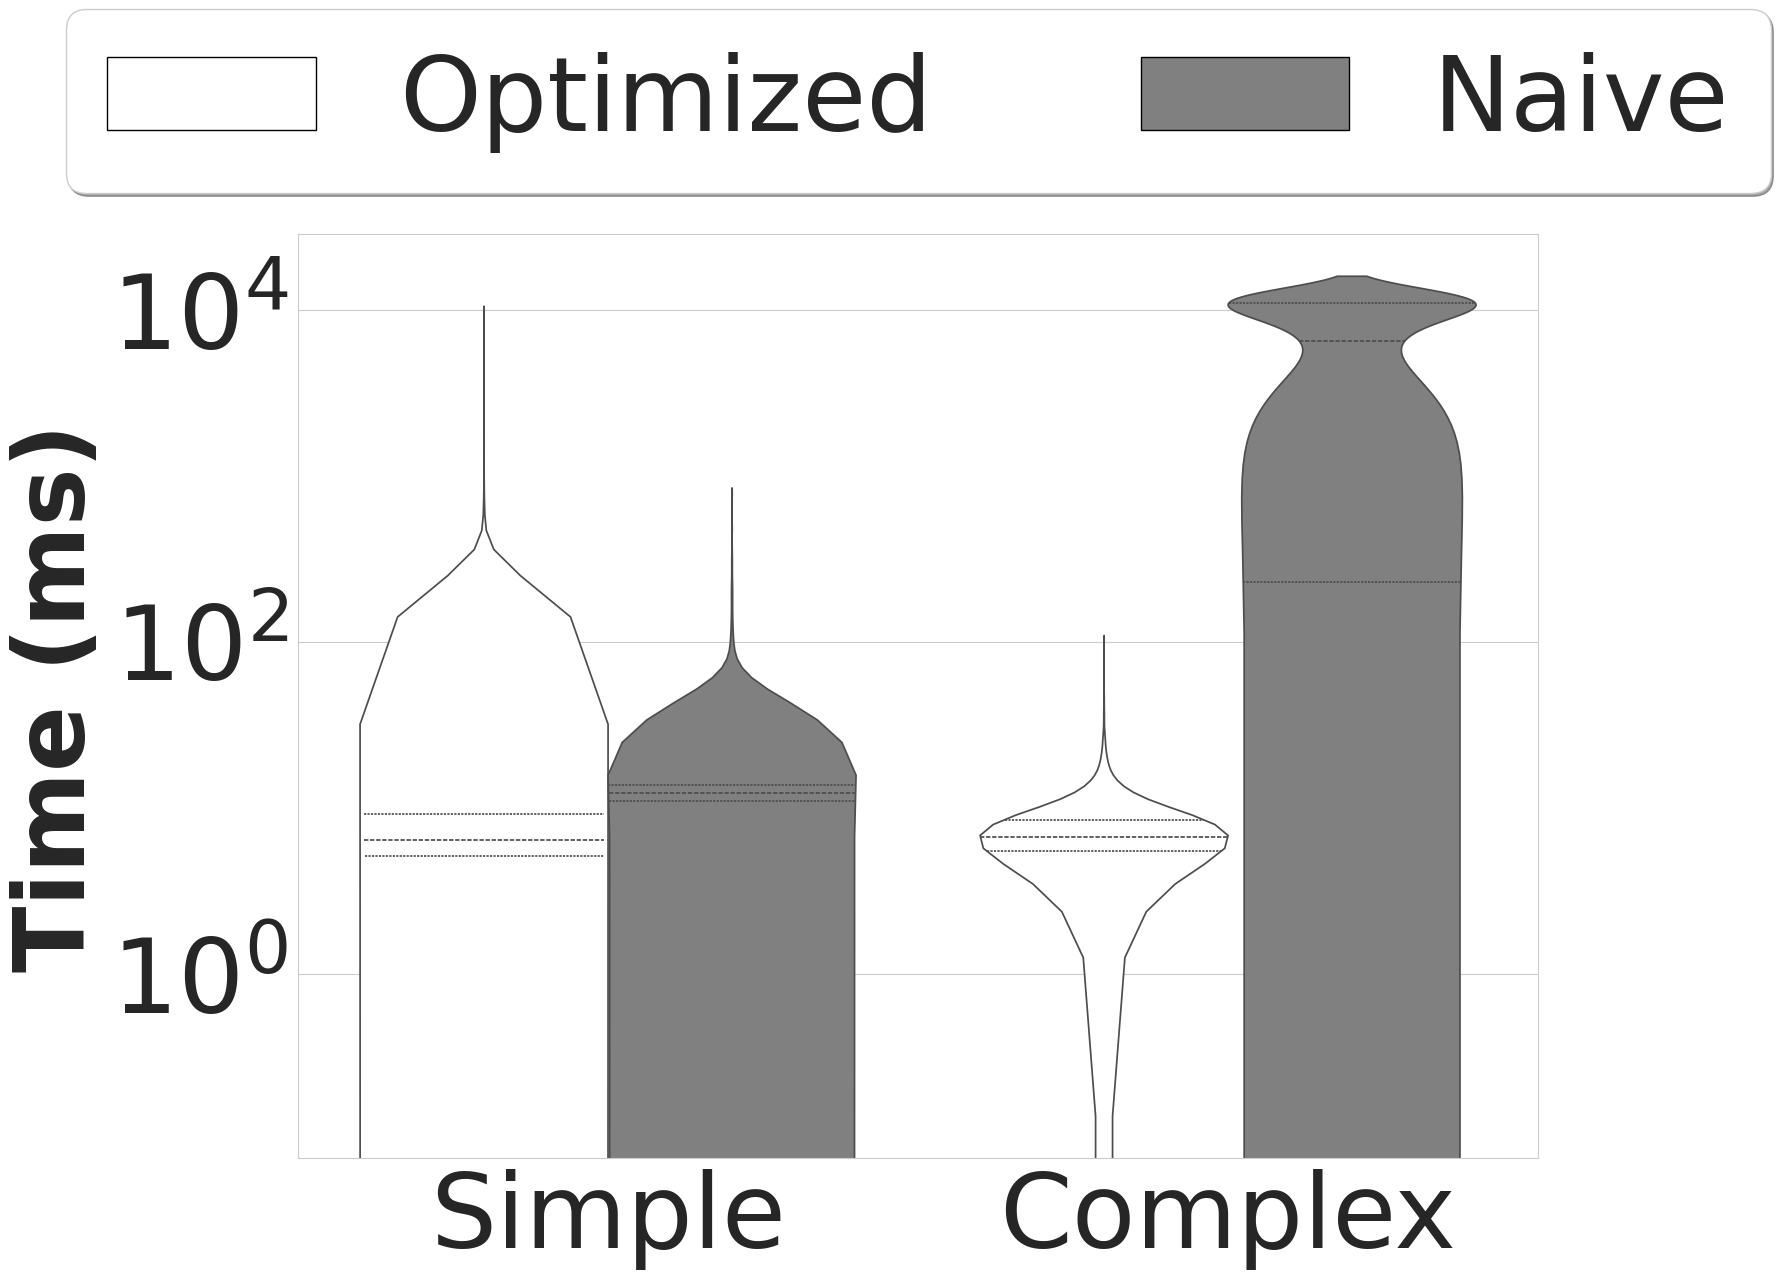

/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


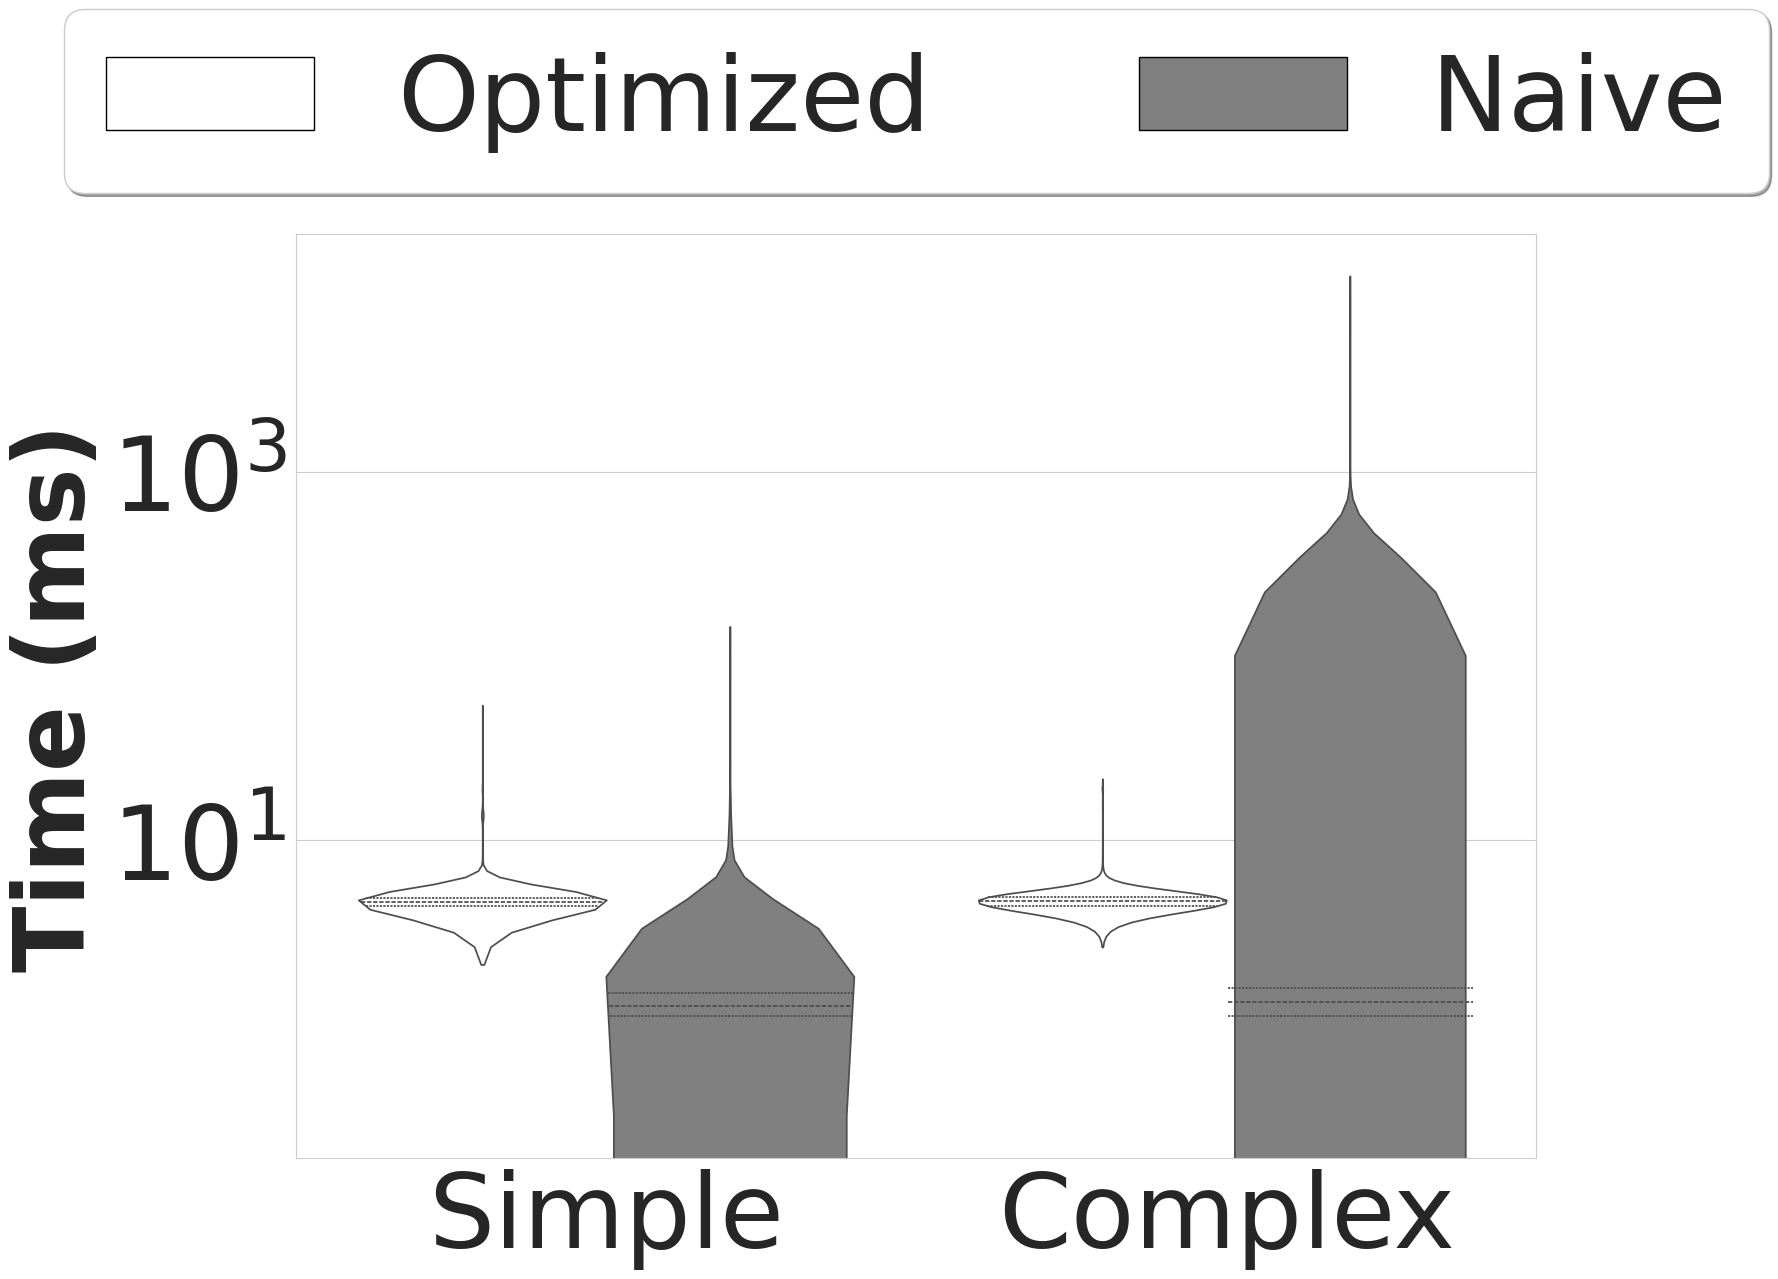

/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


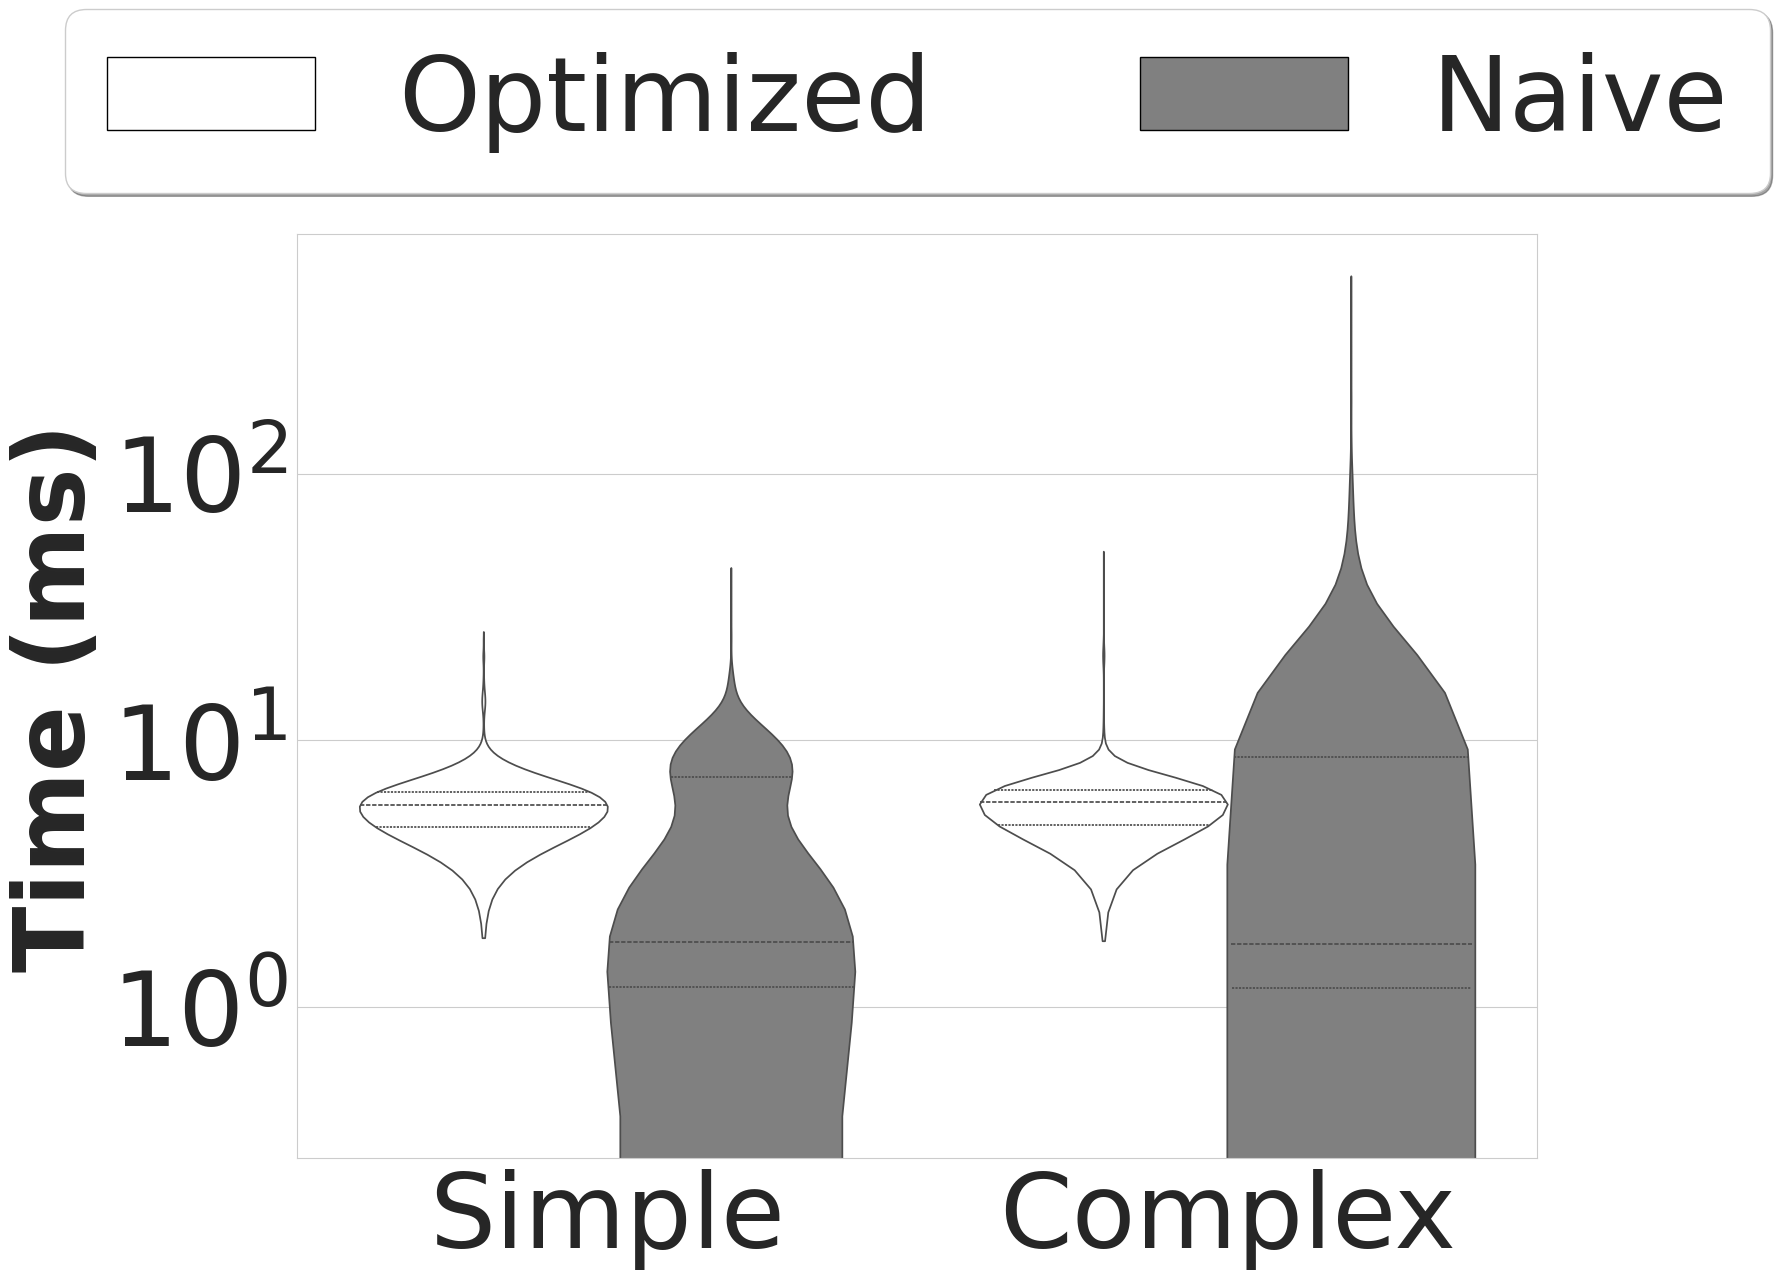

/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


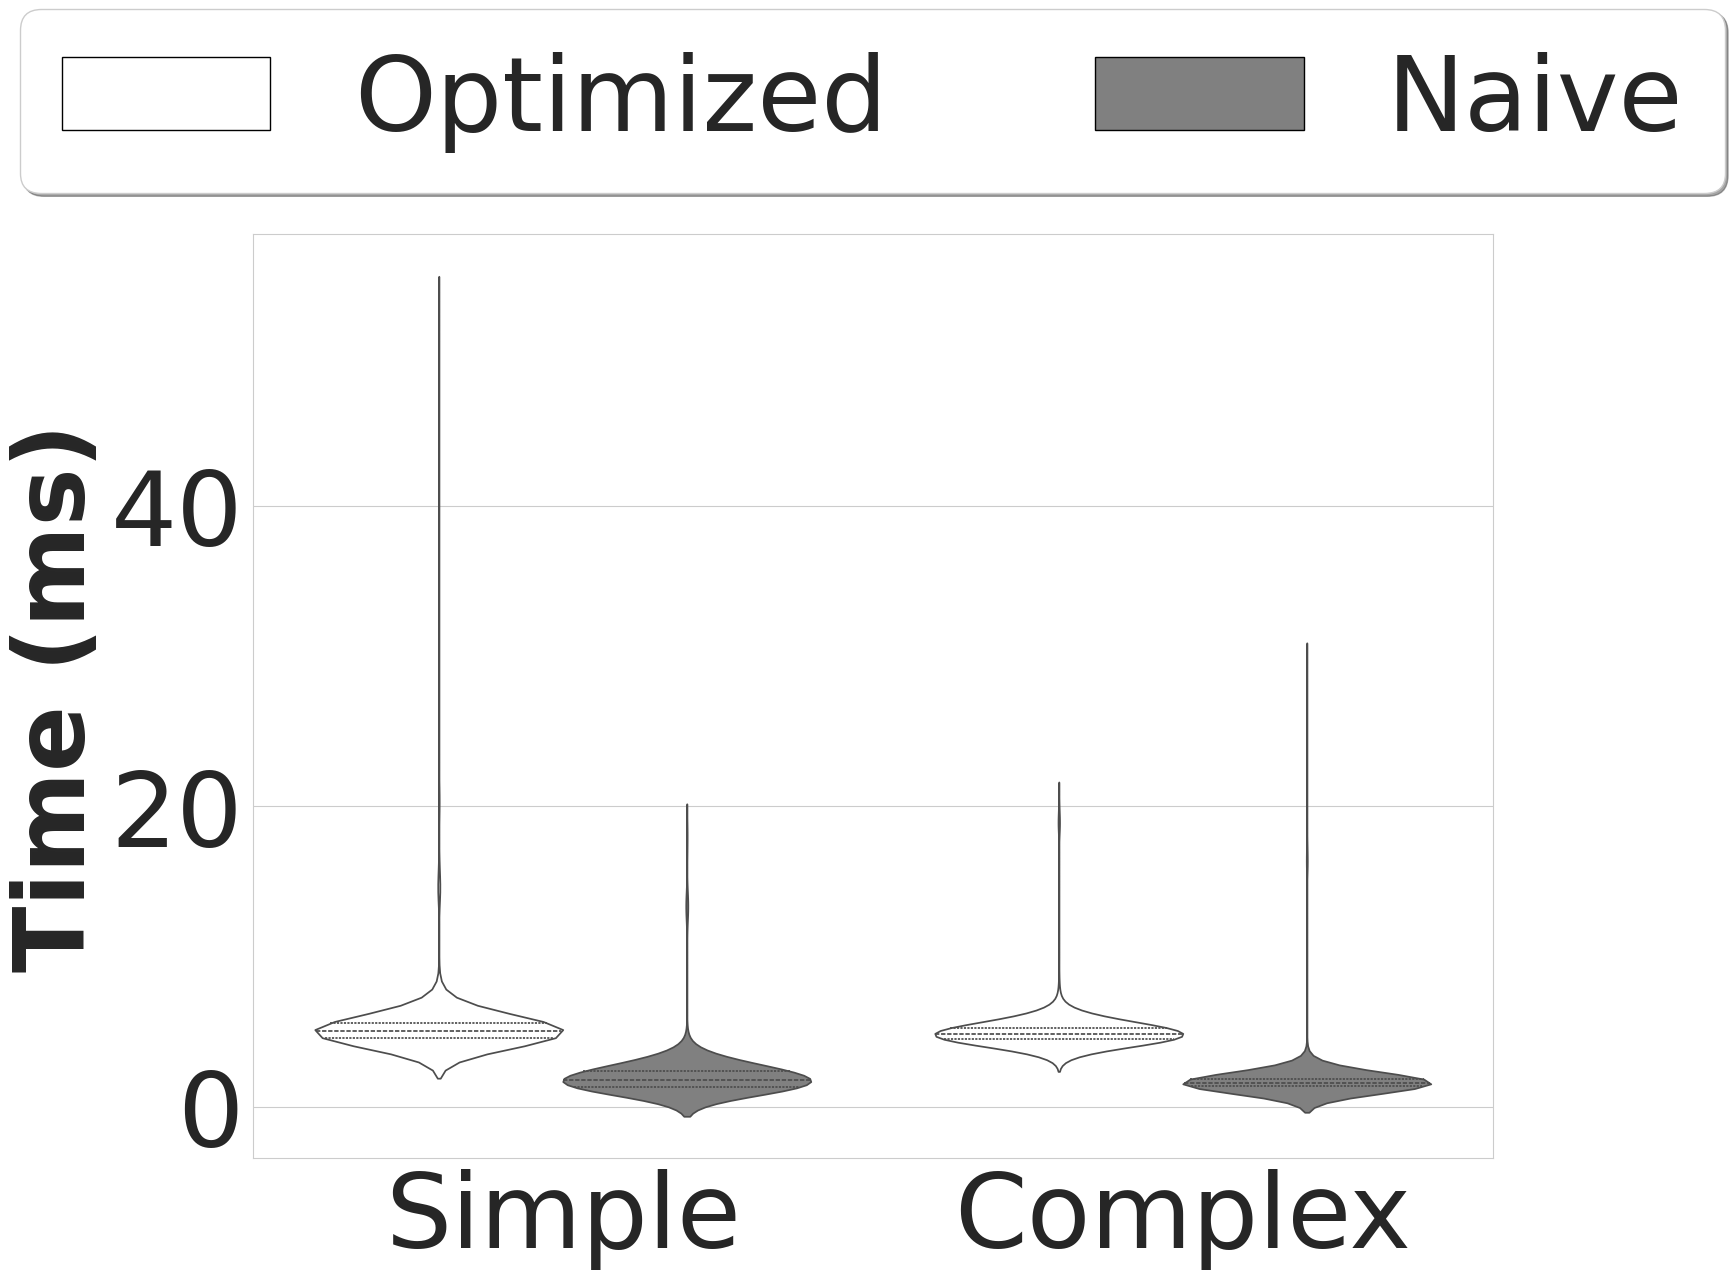

/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


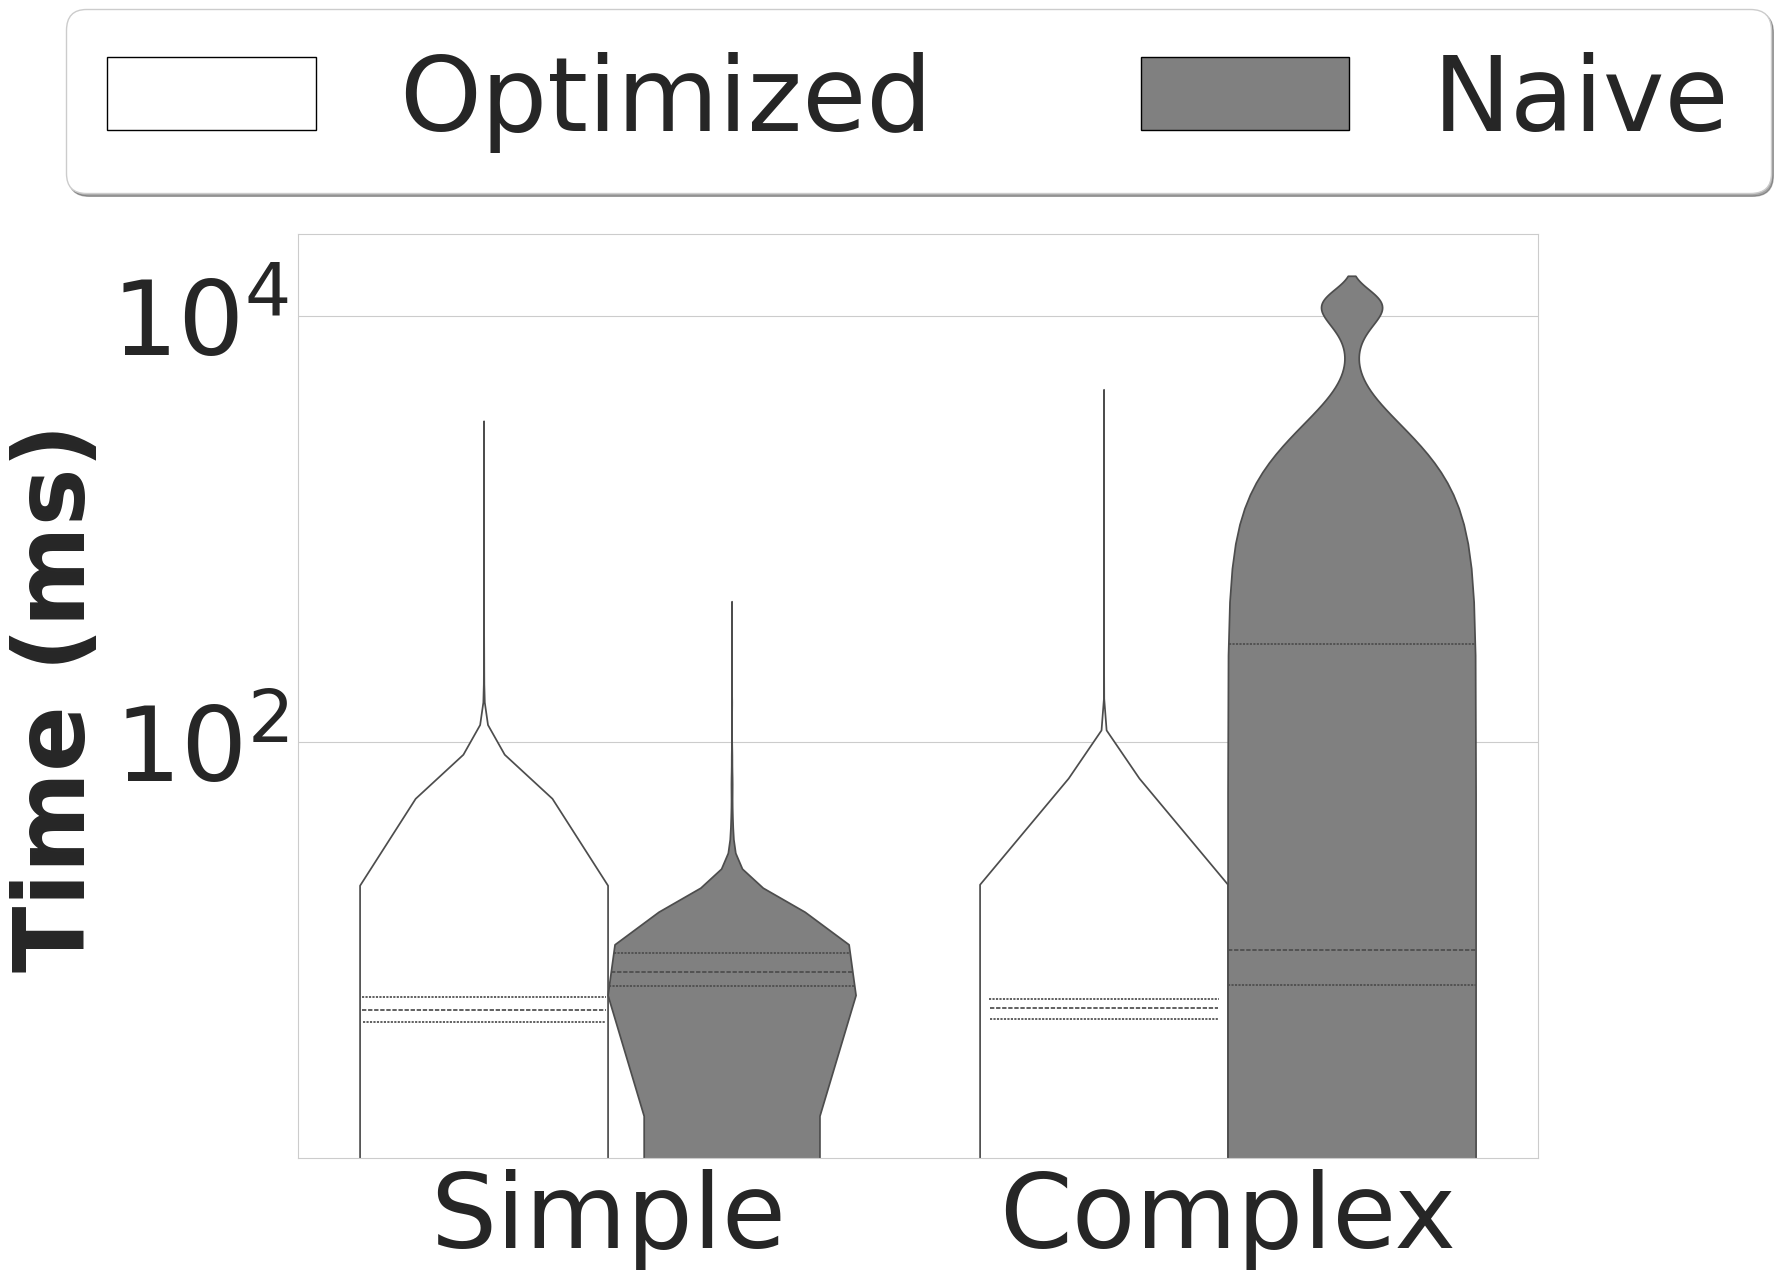

/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:63: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.5`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  violin = sns.violinplot(data=df, x='Constraint_Complexity', y='Time',
/tmp/ipykernel_121660/556773287.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Simple', 'Complex'], fontsize=75)


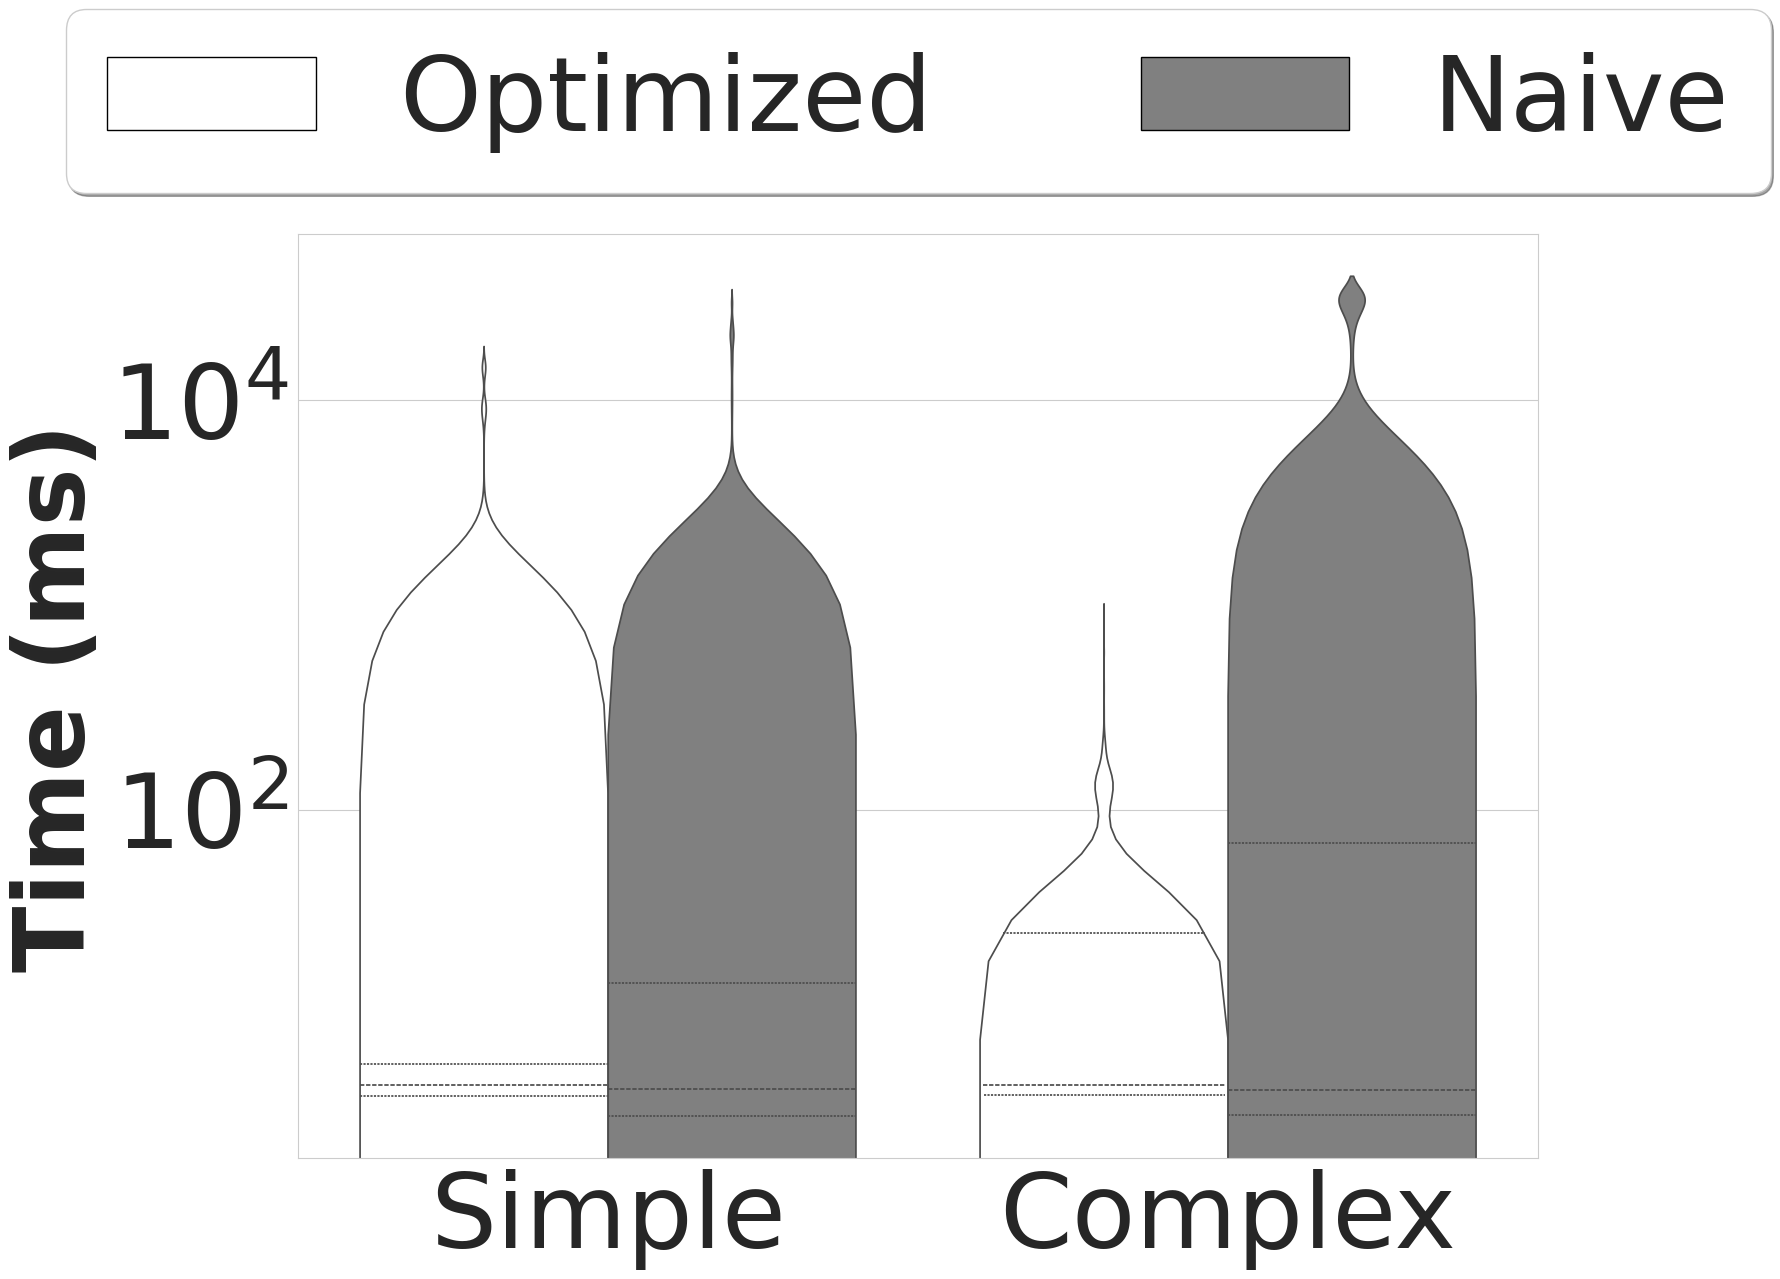

,Query,Data Constraint,Dataset,Time,IsTimeout,Constraint_Complexity
0,Q1,D1,Optimized,67.777438,False,Simple
1,Q1,D1,Optimized,18.429067,False,Simple
2,Q1,D1,Optimized,16.277072,False,Simple
3,Q1,D1,Optimized,14.179999,False,Simple
4,Q1,D1,Optimized,5.115664,False,Simple
...,...,...,...,...,...,...
11995,Q12,D5,Naive,7.238986,False,Complex
11996,Q12,D5,Naive,24.036976,False,Complex
11997,Q12,D5,Naive,4.709398,False,Complex
11998,Q12,D5,Naive,30966.055344,True,Complex


In [14]:
plot_time_distribution_by_constraint("ldbc10/ldbc10_statistic.pkl", "ldbc10-naive/ldbc10_naive_statistic.pkl", ds="LDBC10", timeout=10)
plot_time_distribution_by_constraint("ldbc01/ldbc01_statistic.pkl", "ldbc01-naive/ldbc01_naive_statistic.pkl", ds="LDBC01", timeout=10)
plot_time_distribution_by_constraint("paradise/icij_paradise_statistic.pkl", "paradise-naive/icij_paradise_naive_statistic.pkl", ds="Paradise", timeout=10)
plot_time_distribution_by_constraint("icij-leak/icij_leak_statistic.pkl", "icij-leak-naive/icij_leak_naive_statistic.pkl", ds="ICIJ", timeout=10)

plot_time_distribution_by_constraint("pokec/pokec_statistic.pkl", "pokec-naive/pokec_naive_statistic.pkl", ds="Pokec", timeout=10)
plot_time_distribution_by_constraint("telecom/telecom_statistic.pkl", "telecom-naive/telecom_naive_statistic.pkl", ds="Telecom", timeout=30)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy.stats as stats
from matplotlib.ticker import *
from matplotlib.cm import get_cmap
import os

def slice_small_log(path):
    f = open(path, "rb+") 
    count = 0 
    res = []
    d = {}
    for qi in range(12):
        d[f"Q{qi+1}"] = {}
    for line in f:
        if "exploration_depth" in line.decode('utf-8'):
            res.append(int(line.decode('utf-8').split(":")[1].strip()))
    for i in range(12):
        for j in range(5):
            d[f"Q{i+1}"][f"D{j+1}"] = res[i*500 + j*100: i*500 + (j+1)*100]
    return d

def load_running_time_data(path, dataset_name):
    """Load running time data from pickle file"""
    with open(path, "rb+") as f:
        data = pickle.loads(f.read())
    
    time_data = {}
    for i in range(12):  # Q1-Q12
        query_key = f"Q{i+1}"
        time_data[query_key] = {}
        
        id = 0
        for dtype in ["RPQ", "D1", "D2", "D3", "D4", "D5"]:
            if id == 0:  # Skip RPQ
                id += 1
                continue
            values = list(map(lambda x: x, data[i*6 + id][2]))
            time_data[query_key][dtype] = values
            id += 1
    
    return time_data

def prepare_raw_data(cardinality_data, runtime_data, dataset_name):
    """Prepare raw data points without statistics"""
    plot_data = []
    
    constraints = ['D1', 'D2', 'D3', 'D4', 'D5']
    
    for query_key in cardinality_data.keys():
        for constraint in constraints:
            if (constraint in cardinality_data[query_key] and 
                constraint in runtime_data[query_key]):
                
                # Get all individual data points
                cardinality_points = cardinality_data[query_key][constraint]
                runtime_points = runtime_data[query_key][constraint]
                
                # Make sure we have the same number of points
                min_length = min(len(cardinality_points), len(runtime_points))
                
                for i in range(min_length):
                    plot_data.append({
                        'dataset': dataset_name,
                        'query': query_key,
                        'constraint': constraint,
                        'cardinality': cardinality_points[i],
                        'runtime': runtime_points[i]
                    })
    
    return pd.DataFrame(plot_data)

def plot_individual_dataset_raw(df, dataset_name, log_scale=False):
    """Create raw scatter plot for an individual dataset"""
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Get unique constraints for coloring
    constraints = df['constraint'].unique()
    colors = plt.cm.Set2(np.linspace(0, 1, len(constraints)))
    color_map = {constraint: color for constraint, color in zip(constraints, colors)}
    
    # Plot each constraint with different color
    for constraint in constraints:
        constraint_df = df[df['constraint'] == constraint]
        ax.scatter(constraint_df['cardinality'], constraint_df['runtime'], 
                  color="grey", s=40, alpha=0.6, 
                  edgecolors='none', label=f'Constraint {constraint}')
    
    # Calculate and display correlation coefficient
    if not df.empty:
        # correlation = np.corrcoef(df['cardinality'], df['runtime'])[0, 1]
        correlation, p = stats.pearsonr(df['cardinality'], df['runtime'])[0:2]
        ax.text(0.05, 0.88, f'Correlation: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=12,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
        
        # Add number of data points
        ax.text(0.05, 0.88, f'Data points: {len(df):,}', 
               transform=ax.transAxes, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not df.empty:
        z = np.polyfit(df['cardinality'], df['runtime'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df['cardinality'].min(), df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=2, alpha=0.8, label='Trend line')
    
    # Set labels and title
    ax.set_xlabel('Cardinality (Exploration Depth)', fontsize=14)
    ax.set_ylabel('Runtime (ms)', fontsize=14)
    ax.set_title(f'Cardinality vs Runtime - {dataset_name}', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10)
    
    # Save figure
    os.makedirs('figure/individual', exist_ok=True)
    fig.savefig(f'figure/individual/{dataset_name}_cardinality_vs_runtime_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.close(fig)
    
    return correlation

def plot_merged_datasets_raw(all_dfs, log_scale=False):
    """Create merged raw scatter plot across all datasets"""
    
    # Combine all datasets
    merged_df = pd.concat(all_dfs.values(), ignore_index=True)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get unique datasets for coloring
    datasets = merged_df['dataset'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(datasets)))
    color_map = {dataset: color for dataset, color in zip(datasets, colors)}
    
    # Plot each dataset with different color
    for dataset in datasets:
        dataset_df = merged_df[merged_df['dataset'] == dataset]
        ax.scatter(dataset_df['cardinality'], dataset_df['runtime'], 
                  color="grey", s=30, alpha=0.5, 
                  edgecolors='none', label=dataset)
    
    # Calculate and display correlation coefficient
    if not merged_df.empty:
        correlation = np.corrcoef(merged_df['cardinality'], merged_df['runtime'])[0, 1]
        ax.text(0.05, 0.88, f'r: {correlation:.3f}', 
               transform=ax.transAxes, fontsize=40)
        
        # Add number of data points
        # ax.text(0.05, 0.88, f'Data points: {len(merged_df):,}', 
        #        transform=ax.transAxes, fontsize=10,
        #        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    # Add trend line
    if not merged_df.empty:
        z = np.polyfit(merged_df['cardinality'], merged_df['runtime'], 2)
        p = np.poly1d(z)
        x_range = np.linspace(merged_df['cardinality'].min(), merged_df['cardinality'].max(), 100)
        ax.plot(x_range, p(x_range), 'black', linestyle='-', 
               linewidth=3, alpha=0.8, label='Overall trend')
    
    # Set labels and title
    ax.set_xlabel('Oracle Query Counts', fontsize=40)
    ax.set_ylabel('Runtime (ms)', fontsize=40)
    ax.tick_params(axis='x', labelsize=40)
    ax.tick_params(axis='y', labelsize=40)
    # ax.set_title('Cardinality vs Runtime (All Datasets)', fontsize=16, pad=20)
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, linestyle='--')
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    legends = [
        Patch([0], [0], hatch='O', color='grey', label="Individual Run",
               alpha=0.5, linestyle='None'),
        Line2D([0], [0], color='black', lw=3, label='Overall Trend') 
    ]
    ax.legend(handles=legends, fontsize=40, loc='upper left', bbox_to_anchor=(1.05, 1))

    # Save figure
    os.makedirs('figure/merged', exist_ok=True)
    fig.savefig('figure/merged/merged_cardinality_vs_runtime_raw.pdf', 
                bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return merged_df, correlation

def print_correlation_summary(correlation_results):
    """Print summary of correlation coefficients"""
    print("\n" + "="*50)
    print("CORRELATION SUMMARY - RAW DATA POINTS")
    print("="*50)
    
    # Create table header
    print(f"{'Dataset':<15} {'Correlation':<12} {'Data Points':<12}")
    print("-" * 40)
    
    # Print each dataset's correlation
    for dataset, (correlation, data_points) in correlation_results.items():
        print(f"{dataset:<15} {correlation:.4f}      {data_points:,}")
    
    # Calculate average correlation
    avg_correlation = np.mean([corr for corr, _ in correlation_results.values()])
    total_points = sum([points for _, points in correlation_results.values()])
    
    print("-" * 40)
    print(f"{'Average':<15} {avg_correlation:.4f}      {total_points:,}")
    print("="*50)

def plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=False):
    """
    Plot raw scatter plots between cardinality and runtime for each dataset
    and then merged together
    
    Parameters:
    -----------
    cardinality_paths : dict
        Dictionary of {dataset_name: cardinality_file_path}
    runtime_paths : dict
        Dictionary of {dataset_name: runtime_file_path}
    log_scale : bool
        Whether to use logarithmic scale
    """
    
    all_dfs = {}
    correlation_results = {}
    
    print("Processing individual datasets (raw data points)...")
    for dataset_name in cardinality_paths.keys():
        if dataset_name in runtime_paths:
            print(f"  Analyzing {dataset_name}...")
            
            # Load data
            cardinality_data = slice_small_log(cardinality_paths[dataset_name])
            runtime_data = load_running_time_data(runtime_paths[dataset_name], dataset_name)
            
            # Prepare raw data
            df = prepare_raw_data(cardinality_data, runtime_data, dataset_name)
            all_dfs[dataset_name] = df
            
            # Plot individual dataset
            correlation = plot_individual_dataset_raw(df, dataset_name, log_scale)
            correlation_results[dataset_name] = (correlation, len(df))
            
            print(f"    {dataset_name}: {len(df):,} data points, correlation: {correlation:.3f}")
    
    # Print correlation summary
    print_correlation_summary(correlation_results)
    
    # Plot merged datasets
    print("\nCreating merged raw plot...")
    merged_df, merged_correlation = plot_merged_datasets_raw(all_dfs, log_scale)
    
    print(f"\nTotal data points across all datasets: {len(merged_df):,}")
    print(f"Overall correlation: {merged_correlation:.3f}")
    print("Analysis complete! Check the 'figure/' directory for plots.")

# Example usage:
# cardinality_paths = {
#     "DBPedia": "path/to/dbpedia_cardinality.log",
#     "YAGO": "path/to/yago_cardinality.log",
#     "Wikidata": "path/to/wikidata_cardinality.log"
# }
#
# runtime_paths = {
#     "DBPedia": "path/to/dbpedia_runtime.pkl",
#     "YAGO": "path/to/yago_runtime.pkl",
#     "Wikidata": "path/to/wikidata_runtime.pkl"
# }
#
# plot_all_datasets_raw(cardinality_paths, runtime_paths, log_scale=True)

Processing individual datasets (raw data points)...
  Analyzing LDBC10...
    LDBC10: 6,000 data points, correlation: -0.008
  Analyzing LDBC01...
    LDBC01: 6,000 data points, correlation: 0.111
  Analyzing Pokec...
    Pokec: 6,000 data points, correlation: 0.959
  Analyzing Telecom...
    Telecom: 6,000 data points, correlation: 0.966
  Analyzing ICIJ-Leak...
    ICIJ-Leak: 6,000 data points, correlation: 0.054
  Analyzing ICIJ-Paradise...
    ICIJ-Paradise: 6,000 data points, correlation: -0.015

CORRELATION SUMMARY - RAW DATA POINTS
Dataset         Correlation  Data Points 
----------------------------------------
LDBC10          -0.0081      6,000
LDBC01          0.1115      6,000
Pokec           0.9586      6,000
Telecom         0.9661      6,000
ICIJ-Leak       0.0544      6,000
ICIJ-Paradise   -0.0155      6,000
----------------------------------------
Average         0.3445      36,000

Creating merged raw plot...


/tmp/ipykernel_784/4046831879.py:190: MatplotlibDeprecationWarning: Passing the edgecolor parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  Patch([0], [0], hatch='O', color='grey', label="Individual Run",
/tmp/ipykernel_784/4046831879.py:190: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch([0], [0], hatch='O', color='grey', label="Individual Run",


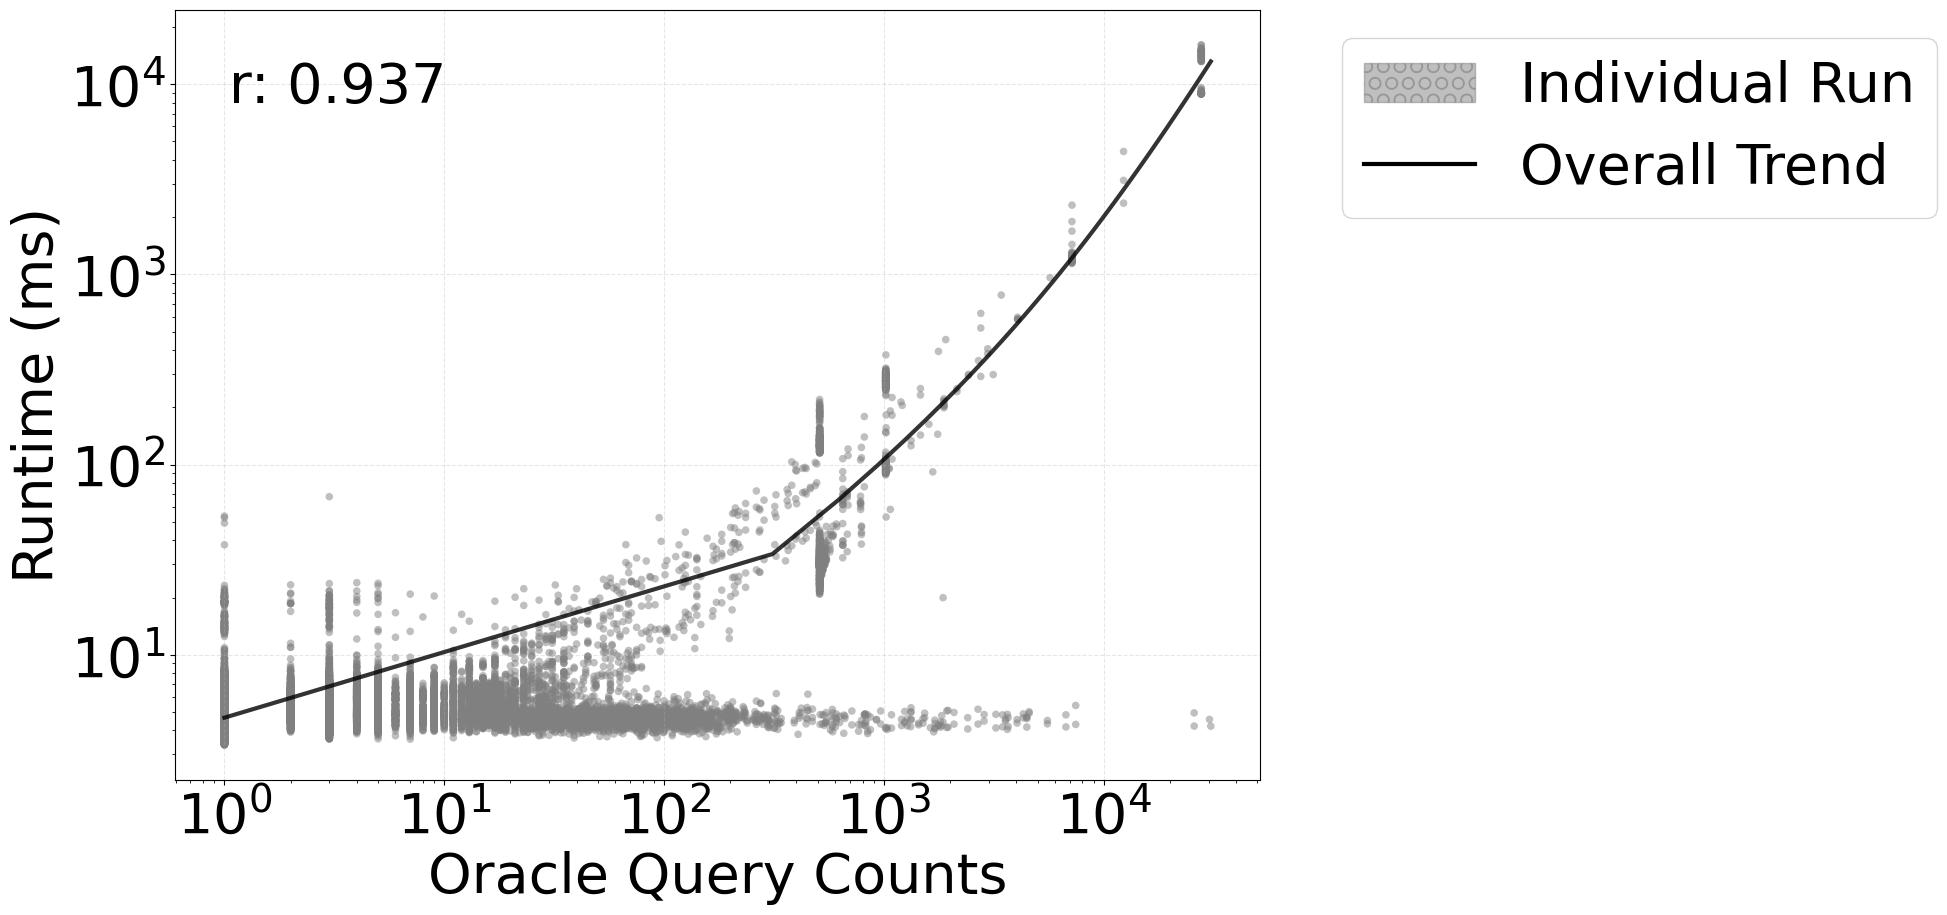


Total data points across all datasets: 36,000
Overall correlation: 0.937
Analysis complete! Check the 'figure/' directory for plots.


In [2]:
dataset_paths = {
        "LDBC10": "ldbc10/z3_debug.log",
        "LDBC01": "ldbc01/z3_debug.log", 
        "Pokec": "pokec/z3_debug.log",
        "Telecom": "telecom/z3_debug.log",
        "ICIJ-Leak": "icij-leak/z3_debug.log",
        "ICIJ-Paradise": "paradise/z3_debug.log"
    }
    
optimized_paths = {"LDBC10":"ldbc01/ldbc01_statistic.pkl", 
         "LDBC01":"ldbc01/ldbc01_statistic.pkl", 
         "Pokec":"pokec/pokec_statistic.pkl",
         "Telecom":"telecom/telecom_statistic.pkl",
         "ICIJ-Leak":"icij-leak/icij_leak_statistic.pkl",
         "ICIJ-Paradise":"paradise/icij_paradise_statistic.pkl"}

dataset_stat ={
            "LDBC10": (30000000, 178000000),
        "LDBC01": (180000, 1500000), 
        "Pokec": (1600000, 30600000),
        "Telecom": (170000, 50000000),
        "ICIJ-Leak": (1900000, 3200000),
        "ICIJ-Paradise": (163000, 364000)
}
    # Plot comparison
plot_all_datasets_raw(dataset_paths, optimized_paths,  log_scale=True)